In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from pycaret.time_series import setup, compare_models, tune_model, predict_model
%cd ..
from src.data_loader import OccupancyData, CaseData
%cd -
mpl.rcParams.update(mpl.rcParamsDefault)
%config InlineBackend.figure_format = 'svg'

/workspaces/hospitalization-model
/workspaces/hospitalization-model/notebooks


In [2]:
START_DATE = "2021-03-30"
END_DATE = "2022-03-30"
FORECAST_DAYS = 14
FOLD = 10

In [3]:
occupancy_data = OccupancyData("../data/hospitalization.csv")
case_data = CaseData("../data/age_groups.csv")
occupancy = occupancy_data.get_df(START_DATE, pd.to_datetime(END_DATE) + pd.Timedelta(days=FORECAST_DAYS), "Österreich", "ICU")
cases = case_data.get_df(START_DATE, pd.to_datetime(END_DATE) + pd.Timedelta(days=FORECAST_DAYS), "Österreich", 
                         age_groups=[">84", "75-84", "65-74", "55-64", "45-54"]).rolling(7, min_periods=1).mean()
data = occupancy.join(cases)

In [4]:
setup(data=data, target="occupancy", fh=FORECAST_DAYS, fold=FOLD)

,Description,Value
0,session_id,2852
1,Target,occupancy
2,Approach,Univariate
3,Exogenous Variables,Present
4,Original data shape,"(380, 2)"
5,Transformed data shape,"(380, 2)"
6,Transformed train set shape,"(366, 2)"
7,Transformed test set shape,"(14, 2)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


In [5]:
best_models = compare_models(n_select=3, exclude=["lar_cds_dt"])

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
arima,ARIMA,0.9074,0.8188,33.4638,39.2007,0.1067,0.1062,-7.6897,0.1310
auto_arima,Auto ARIMA,0.9933,0.8940,36.5249,42.8484,0.1116,0.1093,-6.7584,10.9230
omp_cds_dt,Orthogonal Matching Pursuit w/ Cond. Deseasonalize & Detrending,1.1133,0.9716,40.4648,46.0660,0.1189,0.1123,-2.7929,0.1450
naive,Naive Forecaster,1.1932,1.0330,43.3571,48.9694,0.1244,0.1156,-2.9827,0.3500
lr_cds_dt,Linear w/ Cond. Deseasonalize & Detrending,1.2385,1.1426,46.5870,56.0356,0.1867,0.1579,-25.1693,0.1910
ridge_cds_dt,Ridge w/ Cond. Deseasonalize & Detrending,1.2386,1.1426,46.5884,56.0370,0.1867,0.1579,-25.1702,0.1410
br_cds_dt,Bayesian Ridge w/ Cond. Deseasonalize & Detrending,1.2722,1.1682,47.7901,57.2330,0.1907,0.1607,-26.0104,0.1480
en_cds_dt,Elastic Net w/ Cond. Deseasonalize & Detrending,1.3186,1.1928,49.5113,58.4031,0.1958,0.1589,-31.4400,0.1500
lasso_cds_dt,Lasso w/ Cond. Deseasonalize & Detrending,1.3217,1.1952,49.6102,58.4994,0.1960,0.1590,-31.4175,0.1600
xgboost_cds_dt,Extreme Gradient Boosting w/ Cond. Deseasonalize & Detrending,1.3557,1.2150,49.9018,58.3165,0.1608,0.1413,-6.8474,0.2540


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,ARIMA,1.0148,0.8453,36.3476,40.0984,0.1810,0.1625,-6.7921


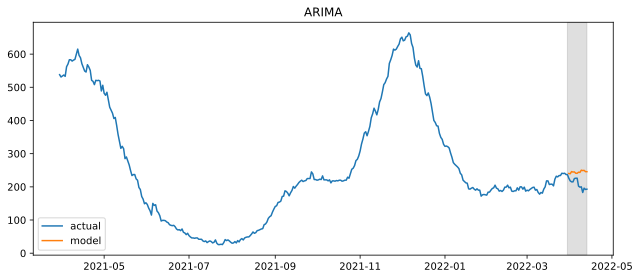

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,Auto ARIMA,0.9948,0.8544,35.6344,40.5314,0.1783,0.1594,-6.9613


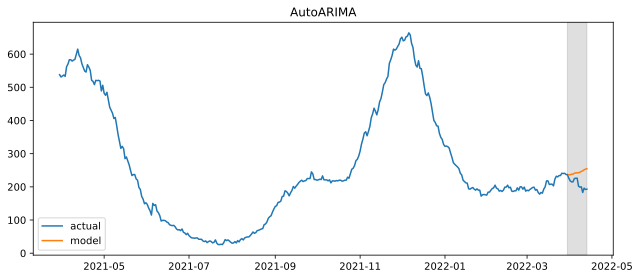

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,OrthogonalMatchingPursuit,0.5905,0.5083,21.1524,24.1116,0.1059,0.0988,-1.8174


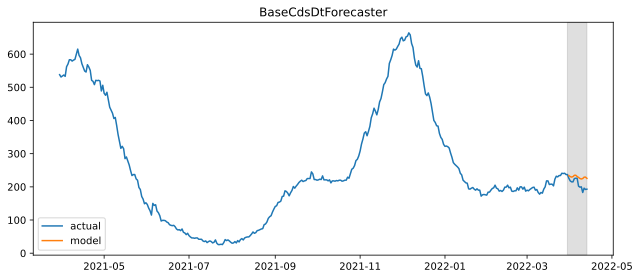

In [6]:
for m in best_models:
    data_tail = data.tail(FORECAST_DAYS)
    predictions = predict_model(m, X=data_tail["cases"])
    plt.figure(figsize=(9, 4))
    plt.plot(data.index, data["occupancy"], label="actual")
    plt.plot(data_tail.index, predictions, label="model")
    plt.axvspan(END_DATE, data.index.max(), alpha=0.25, color='grey')
    plt.title(type(m).__name__)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'plots/timeseries_{type(m).__name__}.pdf')
    plt.show()